In [6]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch_scatter
import os
from IPython.display import clear_output
from sklearn.manifold import TSNE
import numpy

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


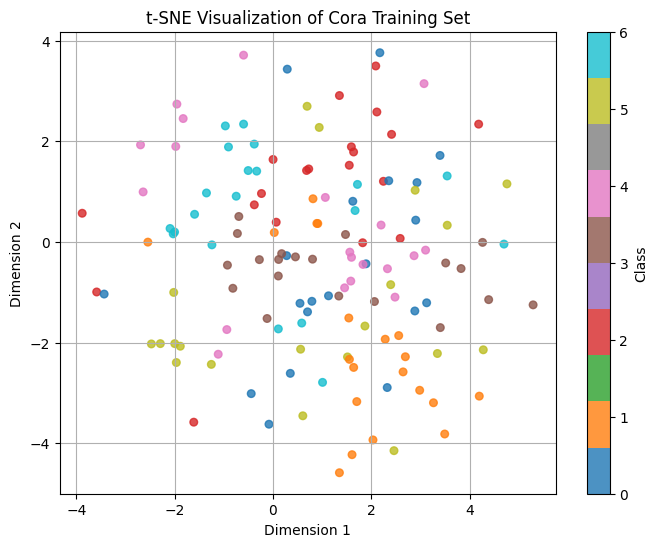

In [ ]:
# Load the Cora dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = Planetoid(root='data', name='Cora', transform=NormalizeFeatures())
data = dataset[0]


train_mask = data.train_mask
x_train = data.x[train_mask]
y_train = data.y[train_mask]

x_train_np = x_train.cpu().numpy()
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
x_train_2d = tsne.fit_transform(x_train_np)
x_train_2d = torch.tensor(x_train_2d)
# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_train_2d[:, 0], x_train_2d[:, 1], c=y_train.cpu(), cmap='tab10', s=30, alpha=0.8)
plt.colorbar(scatter, label='Class')
plt.title('t-SNE Visualization of Cora Training Set')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

In [9]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels, k=1):
        super(GCNConv, self).__init__(aggr='add')
        self.linear = nn.Linear(in_channels, out_channels)
        self.k = k

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Compute normalization
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        x = self.linear(x)

        for _ in range(self.k):
            x = self.propagate(edge_index, x=x, norm=norm)

        return x

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

    def aggregate(self, inputs, index, dim_size=None):
        return torch_scatter.scatter(inputs, index, dim=0, dim_size=dim_size, reduce='add')

    def update(self, aggr_out):
        return aggr_out

In [10]:
os.makedirs("tsne_frames", exist_ok=True)

In [11]:
def save_tsne_frame(epoch, model, data):
    model.eval()
    with torch.no_grad():
        # Extract features after first GCN layer
        x = F.relu(model.layers[0](data.x, data.edge_index))
        train_mask = data.train_mask
        x_train = x[train_mask].cpu().numpy()
        y_train = data.y[train_mask].cpu().numpy()

        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        x_2d = tsne.fit_transform(x_train)

        # Save plot
        plt.figure(figsize=(7, 6))
        scatter = plt.scatter(x_2d[:, 0], x_2d[:, 1], c=y_train, cmap='tab10', s=30, alpha=0.8)
        plt.colorbar(scatter, label='Class')
        plt.title(f't-SNE (Training Set) — Epoch {epoch}')
        plt.xlabel('dim 1')
        plt.ylabel('dim 2')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"tsne_frames/tsne_epoch_{epoch:03d}.png")
        plt.close()

In [12]:
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

def show_tsne_animation():
    # Load images into frames
    frame_paths = sorted([f"tsne_frames/{f}" for f in os.listdir("tsne_frames") if f.endswith(".png")])
    frames = [Image.open(fp) for fp in frame_paths]

    # Create animation using matplotlib
    fig, ax = plt.subplots(figsize=(7, 6))
    img = plt.imshow(frames[0])
    plt.axis('off')

    def update(i):
        img.set_data(frames[i])
        return [img]

    ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=500)
    plt.close(fig)
    return HTML(ani.to_jshtml())

In [17]:
class StackedGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()
        # create a ModuleList called "layers"
        self.layers = nn.ModuleList()
        # first layer
        self.layers.append(GCNConv(in_channels, hidden_channels, k=1))
        # middle layers (if num_layers > 2)
        for _ in range(num_layers - 2):
            self.layers.append(GCNConv(hidden_channels, hidden_channels, k=1))
        # final layer
        self.layers.append(GCNConv(hidden_channels, out_channels, k=1))
        # a small MLP on top
        self.mlp = nn.Linear(out_channels, out_channels)

    def forward(self, x, edge_index):
        # apply all but last with ReLU
        for conv in self.layers[:-1]:
            x = F.relu(conv(x, edge_index))
        # last GCN layer
        x = self.layers[-1](x, edge_index)
        # final MLP
        return self.mlp(x)

In [18]:
class SingleKHopGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, k):
        super().__init__()
        # again expose as "layers"
        self.layers = nn.ModuleList()
        # one k‑hop GCN
        self.layers.append(GCNConv(in_channels, hidden_channels, k=k))
        # then a standard 1-hop to get to out_channels
        self.layers.append(GCNConv(hidden_channels, out_channels, k=1))
        self.mlp = nn.Linear(out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.layers[0](x, edge_index))
        x = self.layers[1](x, edge_index)
        return self.mlp(x)

In [19]:
def train(model, data, epoch_num):
    model.to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    for epoch in range(1, epoch_num + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch % 20 == 0:
            save_tsne_frame(epoch, model, data)


def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[data.test_mask] == data.y[data.test_mask]
    return int(correct.sum()) / int(data.test_mask.sum())


K = 2  # Number of layers / hops
hidden_channels = 32

model1 = StackedGCN(
    in_channels=dataset.num_node_features,
    hidden_channels=hidden_channels,
    out_channels=dataset.num_classes,
    num_layers=K
)

train(model1, data, epoch_num=201)
acc1 = test(model1, data)
print(f"Stacked GCN ({K} layers, k=1 each): Test Accuracy = {acc1:.4f}")
show_tsne_animation()  # Assuming defined elsewhere


Stacked GCN (2 layers, k=1 each): Test Accuracy = 0.7700


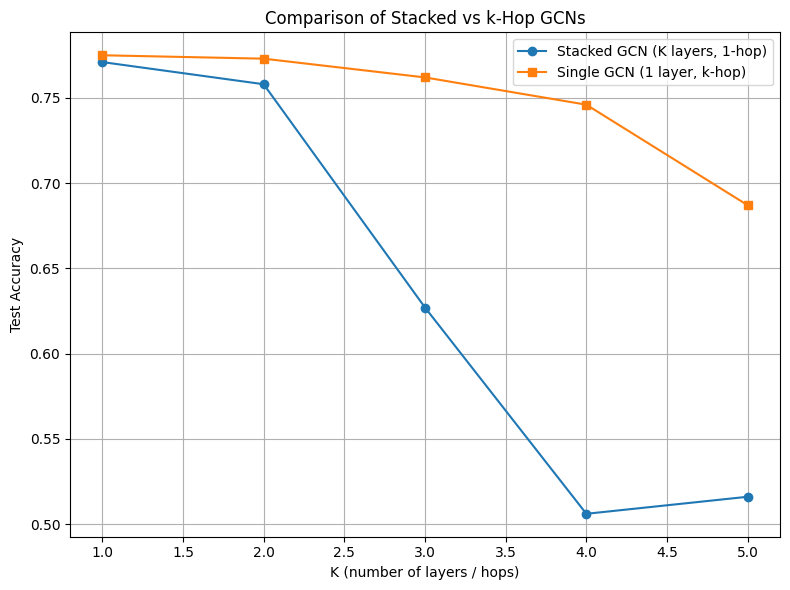

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

Ks = range(1, 6)
accs_model1 = []
accs_model2 = []

for K in Ks:
        model1 = StackedGCN(
            in_channels=dataset.num_node_features,
            hidden_channels=hidden_channels,
            out_channels=dataset.num_classes,
            num_layers=K
        ).to(device)
        model2 = SingleKHopGCN(
            in_channels=dataset.num_node_features,
            hidden_channels=hidden_channels,
            out_channels=dataset.num_classes,
            k=K
        ).to(device)

        train(model1, data, epoch_num=201)
        train(model2, data, epoch_num=201)

        acc1 = test(model1, data)
        acc2 = test(model2, data)

        accs_model1.append(acc1)
        accs_model2.append(acc2)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(Ks, accs_model1, marker='o', label='Stacked GCN (K layers, 1-hop)')
plt.plot(Ks, accs_model2, marker='s', label='Single GCN (1 layer, k-hop)')
plt.xlabel("K (number of layers / hops)")
plt.ylabel("Test Accuracy")
plt.title("Comparison of Stacked vs k-Hop GCNs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()